In [55]:
import nd2
import numpy as np
import napari
from skimage.measure import label, regionprops, regionprops_table
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
img = nd2.imread('./raw_data/240515_40x_cameraAlignment_largerGreen - Denoised_registered.nd2')

In [36]:
img.shape

(2, 2720, 2720)

In [37]:
ch_0 = img[0,:,:]
ch_1 = img[1,:,:]

In [38]:
threshold_ch0 = 1200
ch_0_mask = ch_0 > threshold_ch0

threshold_ch1 = 220
ch_1_mask = ch_1 > threshold_ch1

In [39]:
# Transform mask into objects using connected component analysis
ch_0_labels = label(ch_0_mask)
ch_1_labels = label(ch_1_mask)

In [40]:
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(ch_0)
viewer.add_labels(ch_0_labels)
viewer.add_image(ch_1)
viewer.add_labels(ch_1_labels)

<Labels layer 'ch_1_labels' at 0x1fddc98aa90>

In [41]:
def calculate_positive_pixels(ch_0_labels, ch_1_labels):
    # Ensure that the input arrays have the same shape
    assert ch_0_labels.shape == ch_1_labels.shape, "Input arrays must have the same shape"

    # Ensure that both channels have the same number of labels
    assert np.max(ch_0_labels) == np.max(ch_1_labels), "Input arrays must have the same number of labels"

    # Define the max number of labels
    label_nr = np.max(ch_0_labels)

    # Create an array that stores a True value for each of the xy positions where both ch_0 and ch_1 labels are present
    positive_both = (ch_0_labels > 0) & (ch_1_labels > 0)

    # Count positive pixels for each label in ch_0

    # Initialize an empty array to store results 
    label_counts = np.zeros(label_nr) 

    # Loop over each label
    for label in range(1, (label_nr + 1)):
        # Update the label_counts array with the sum of pixels for each ch0 labelled pixel that is also present in ch1 (positive both)
        label_counts[label - 1] = np.sum((ch_0_labels == label) & positive_both)

    # Calculate the total number of pixels for each label in ch_0_labels
    total_label_counts = np.array([np.sum(ch_0_labels == label) for label in range(1, (label_nr + 1))])
    # Calculate the percentage of positive pixels for both labels
    percentage_positive_both = (label_counts / total_label_counts) * 100
    
    return label_counts, percentage_positive_both

# Example usage
label_counts, percentage_positive_both = calculate_positive_pixels(ch_0_labels, ch_1_labels)


In [46]:
def calculate_props(label_image, intensity_image):

    df = regionprops_table(label_image ,intensity_image, properties=['label','area_filled','area','intensity_mean'])

    return df


In [53]:
results_ch0 = calculate_props(ch_0_labels, ch_0)

results_ch1 = calculate_props(ch_1_labels, ch_1)

In [ ]:
results_ch0['intensity_mean']

In [54]:
df_ch0 = pd.DataFrame(results_ch0)
df_ch1 = pd.DataFrame(results_ch1)


,label,area_filled,area,intensity_mean
0,1,187.0,145.0,1564.110345
1,2,191.0,151.0,1624.331126
2,3,197.0,161.0,1743.130435
3,4,199.0,167.0,1806.538922
4,5,200.0,168.0,1824.565476
...,...,...,...,...
76,77,192.0,159.0,1761.314465
77,78,188.0,155.0,1767.929032
78,79,182.0,149.0,1693.872483
79,80,175.0,136.0,1603.720588


In [60]:
def plot_percentage_on_image(ch_0_labels, array):
    plt.figure(figsize=(10, 10))
    plt.imshow(ch_0_labels, cmap='gray')
    
    for label in range(1, np.max(ch_0_labels) + 1):
        positions = np.column_stack(np.where(ch_0_labels == label))
        if len(positions) > 0:
            # Choose the first position found for each label to display the percentage
            y, x = positions[0]
            plt.text(x, y - 2, f'{array[label - 1]:.2f}%', color='red', fontsize=8, ha='center')

    plt.title('Percentage of Positive Pixels for Both Labels')
    plt.axis('off')
    plt.show()


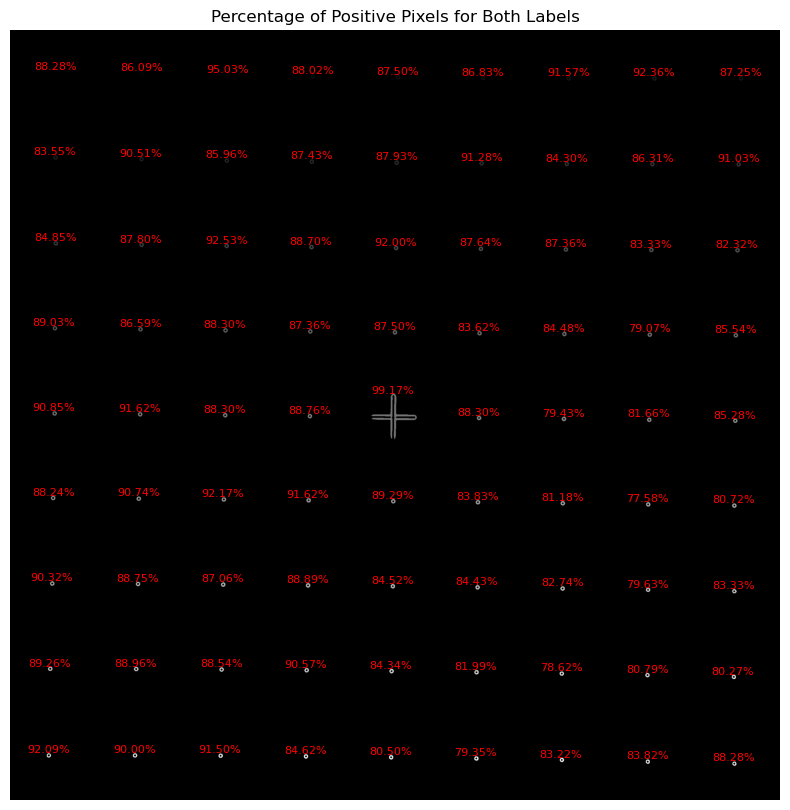

In [61]:
plot_percentage_on_image(ch_0_labels, percentage_positive_both)

In [68]:
def plot_intensity_on_image(ch_0_labels, array):
    plt.figure(figsize=(10, 10))
    plt.imshow(ch_0_labels, cmap='gray')
    
    for label in range(1, np.max(ch_0_labels) + 1):
        positions = np.column_stack(np.where(ch_0_labels == label))
        if len(positions) > 0:
            # Choose the first position found for each label to display the percentage
            y, x = positions[0]
            plt.text(x, y - 2, f'{array[label - 1]:.2f}', color='white', fontsize=8, ha='center')

    plt.title('Mean intensity for each label')
    plt.axis('off')
    plt.show()

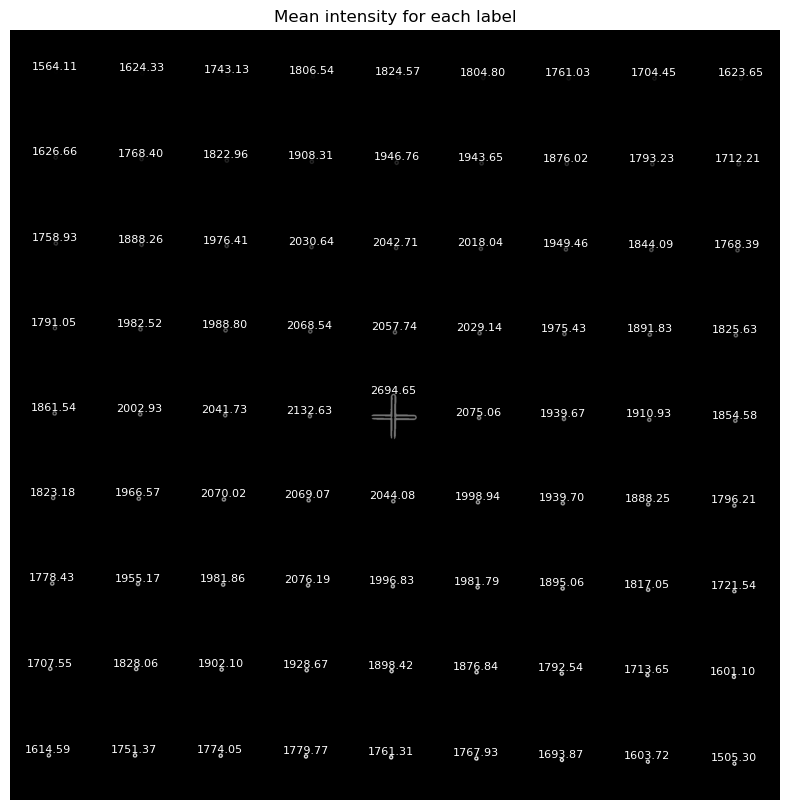

In [69]:
plot_intensity_on_image(ch_0_labels, results_ch0['intensity_mean'])